In [2]:
import random
import string
from typing import TypedDict
from langgraph.graph import StateGraph, END
from langgraph.graph import StateGraph

from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_ollama.chat_models import ChatOllama
from langchain_core.messages import HumanMessage
from tqdm import tqdm
import time, re

llm = ChatOllama(
    model="llama3.1:latest",
    temperature=0.0,
    base_url="http://localhost:11434",
    api_key="ollama"
)

In [1]:
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import END, MessageGraph, StateGraph

from typing import List, Sequence
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [5]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a professional LinkedIn content assistant tasked with crafting engaging, insightful, and well-structured LinkedIn posts."
            " Generate the best LinkedIn post possible for the user's request."
            " If the user provides feedback or critique, respond with a refined version of your previous attempts, improving clarity, tone, or engagement as needed.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [4]:
generation_prompt

ChatPromptTemplate(input_variables=['messages'], input_types={'messages': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.Annotated[langchain_core.mes

In [6]:
generate_chain = generation_prompt | llm

In [7]:
reflection_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        """You are a professional LinkedIn content strategist and thought leadership expert. Your task is to critically evaluate the given LinkedIn post and provide a comprehensive critique. Follow these guidelines:

        1. Assess the post’s overall quality, professionalism, and alignment with LinkedIn best practices.
        2. Evaluate the structure, tone, clarity, and readability of the post.
        3. Analyze the post’s potential for engagement (likes, comments, shares) and its effectiveness in building professional credibility.
        4. Consider the post’s relevance to the author’s industry, audience, or current trends.
        5. Examine the use of formatting (e.g., line breaks, bullet points), hashtags, mentions, and media (if any).
        6. Evaluate the effectiveness of any call-to-action or takeaway.

        Provide a detailed critique that includes:
        - A brief explanation of the post’s strengths and weaknesses.
        - Specific areas that could be improved.
        - Actionable suggestions for enhancing clarity, engagement, and professionalism.

        Your critique will be used to improve the post in the next revision step, so ensure your feedback is thoughtful, constructive, and practical.
        """
    ),
    MessagesPlaceholder(variable_name="messages")
])

In [8]:
reflect_chain = reflection_prompt | llm

In [9]:
from langgraph.graph import MessageGraph
from typing import List, Annotated, TypedDict
from langchain.schema import HumanMessage, AIMessage, SystemMessage

# Initialize a predefined MessageGraph
graph = MessageGraph()

In [10]:
def generation_node(state: Sequence[BaseMessage]) -> List[BaseMessage]:
    generated_post = generate_chain.invoke({"messages": state})
    return [AIMessage(content=generated_post.content)]

In [11]:
def reflection_node(messages: Sequence[BaseMessage]) -> List[BaseMessage]:
    res = reflect_chain.invoke({"messages": messages})  # Passes messages as input to reflect_chain
    return [HumanMessage(content=res.content)]  # Returns the refined message as HumanMessage for feedback

In [12]:
graph.add_node("generate", generation_node)
graph.add_node("reflect", reflection_node)
graph.add_edge("reflect", "generate")
graph.set_entry_point("generate")

In [13]:
def should_continue(state: List[BaseMessage]):
    print(state)
    print(len(state))
    print("----------------------------------------------------------------------")
    if len(state) > 6:
        return END
    return "reflect"

In [14]:
graph.add_conditional_edges("generate", should_continue)

In [15]:
workflow = graph.compile()

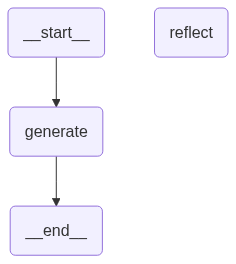

In [16]:
workflow

In [17]:
inputs = HumanMessage(content="""Write a linkedin post on getting a software developer job at IBM under 160 characters""")

In [18]:
response = workflow.invoke(inputs)

[HumanMessage(content='Write a linkedin post on getting a software developer job at IBM under 160 characters', additional_kwargs={}, response_metadata={}, id='4ab562b2-28a8-4de8-a76b-99d9532d0732'), AIMessage(content='"Ready to code for a global leader? Check out IBM\'s latest software dev openings and take the first step towards an exciting career! [link to IBM careers page] #IBM #SoftwareDeveloper #CareerOpportunities"', additional_kwargs={}, response_metadata={}, id='5287c449-a3e0-466b-9e0b-35f15b1d2f89')]
2
----------------------------------------------------------------------
[HumanMessage(content='Write a linkedin post on getting a software developer job at IBM under 160 characters', additional_kwargs={}, response_metadata={}, id='4ab562b2-28a8-4de8-a76b-99d9532d0732'), AIMessage(content='"Ready to code for a global leader? Check out IBM\'s latest software dev openings and take the first step towards an exciting career! [link to IBM careers page] #IBM #SoftwareDeveloper #CareerOp

In [19]:
response[1].content

'"Ready to code for a global leader? Check out IBM\'s latest software dev openings and take the first step towards an exciting career! [link to IBM careers page] #IBM #SoftwareDeveloper #CareerOpportunities"'

In [22]:
response[3].content

'Here\'s another attempt at a LinkedIn post on getting a software developer job at IBM under 160 characters:\n\n"Dreaming of coding for IBM? Explore our latest software dev openings and kickstart your career with the global tech leader! [link to IBM careers page] #IBM #SoftwareDev #CareerGoals"'

In [24]:
response[5].content

'Here\'s another attempt at a LinkedIn post on getting a software developer job at IBM under 160 characters:\n\n"Want to code for IBM? Explore our latest software dev openings and join the global tech leader! [link to IBM careers page] #IBM #SoftwareDeveloper #DreamJob"'

In [21]:
response[-1].content

'Here\'s another attempt at a LinkedIn post on getting a software developer job at IBM under 160 characters:\n\n"Code for IBM? Explore our latest software dev openings and take your career to the next level! [link to IBM careers page] #IBM #SoftwareDev #CareerGrowth"'

In [25]:
from IPython.display import Image, display

display(Image(workflow.get_graph().draw_png()))

ImportError: Install pygraphviz to draw graphs: `pip install pygraphviz`.